<a href="https://colab.research.google.com/github/Mateoz18/ANALITICA3/blob/main/4_Modelo_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='056938'> **Librerias** </font>

In [ ]:
from google.colab import drive
import sys
import os
import numpy as np
import pandas as pd
import sqlite3 as sql
from ipywidgets import interact ## para análisis interactivo
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_distances
from ipywidgets import interact
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn import set_config

In [ ]:
drive.mount('/content/drive')

#Define la parte del directorio que quieres trabajar
path = "/content/drive/MyDrive/Mod2/ANALITICA3"

sys.path.append(path)##para importar archivo de funciones propias a traves de import
os.chdir(path)## para que por defecto suba y descargue archivos partiendo de esa ruta
sys.path.append(f"{path}") #agragarle al path, poder leer

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# <font color='056938'> **Cargar base de datos** </font>

In [ ]:
con=sql.connect("data//db_movies")# conectarse a base de datos existente
cur=con.cursor()#otro tipo de conexión para ejecutar consultas en la base de datos sin traer ni llevar información

In [ ]:
cur.execute("""SELECT name FROM sqlite_master WHERE type='table'""")
cur.fetchall()

[('ratings',),
 ('movies',),
 ('usuarios_sel',),
 ('peliculas_sel',),
 ('ratings_final',),
 ('movies_final',),
 ('full_ratings',)]

In [ ]:
tabla_completa = pd.read_sql("SELECT * FROM full_ratings", con)
tabla_completa.head()

,user_id,movie_id,movie_title,movie_genres,movie_rating,movie_timestamp,movie_year
0,1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,4.0,964982703,1995
1,1,3,Grumpier Old Men,Comedy|Romance,4.0,964981247,1995
2,1,6,Heat,Action|Crime|Thriller,4.0,964982224,1995
3,1,47,Seven (a.k.a. Se7en),Mystery|Thriller,5.0,964983815,1995
4,1,50,"Usual Suspects, The",Crime|Mystery|Thriller,5.0,964982931,1995


# <font color='056938'> **Sistema de recomendación basado en ítems** </font>

Este sistema usa las similitudes entre las películas basadas en las calificaciones de los usuarios. Si los usuarios que han calificado una película también han calificado otras de manera similar, esas otras películas son recomendadas.

Para esto, se construye un **pipeline** que contiene los siguientes pasos:

**Paso 1. Construcción de la matriz película-usuario**: Se construye una matriz de película-usuario con los ratings disponibles. Esta matriz tiene como filas las películas y como columnas los usuarios, donde cada celda contiene la calificación (rating) que un usuario ha dado a una película. Si un usuario no ha valorado una película, se asigna un valor de cero.

**Paso 2. Modelo KNN con métrica de similitud coseno**: Se entrena un modelo **K-Nearest Neighbors (KNN)** utilizando la similitud del coseno como métrica. Este modelo permite identificar películas similares entre sí, comparando vectores de calificaciones. La similitud del coseno mide el ángulo entre los vectores, por lo que dos películas son consideradas similares si fueron calificadas de manera parecida por los mismos usuarios, independientemente de la magnitud de las calificaciones.

**Ejemplo de la similitud del coseno**: Tenemos 3 usuarios y las siguientes calificaciones:

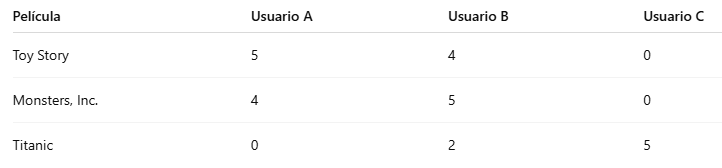

* Toy Story y Monsters, fueron calificadas por los mismos usuarios (A y B). Sus ratings no son idénticos, pero la proporción entre ellos es parecida. Por eso, la similitud del coseno será alta entre ellas (vectores similares en dirección).

* Por otro lado, titanic solo fue calificada por B y C, con una lógica distinta.Entonces, su vector apunta en una dirección distinta, y tendrá baja similitud con Toy Story o Monsters.

In [ ]:
# Construcción de la matriz película-usuario
class movie_usuario_matriz(BaseEstimator, TransformerMixin):
    # Método fit: Este es el método que se usa para entrenar el transformador
    def fit(self, tabla_completa, y=None):
        return self
    # Método transform: Este es el método que se usa para transformar los datos de entrada y crear la matriz película-usuario.
    def transform(self, tabla_completa):
        movie_usuario_matriz = tabla_completa.pivot_table(index='movie_title', columns='user_id', values='movie_rating').fillna(0)
        return movie_usuario_matriz


In [ ]:
# Pipeline completo
pipeline = Pipeline([
     #Paso 1. Construcción de la matriz película-usuario
    ('crear_matriz', movie_usuario_matriz()),
     #Paso 2. Modelo KNN con métrica de similitud coseno
    ('knn', NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=11))# 10 peliculas similares
])

In [ ]:
# Llamar al paso 'crear_matriz' y aplicarle transform() a tus datos
movie_usuario_matriz = pipeline.named_steps['crear_matriz'].transform(tabla_completa)
movie_usuario_matriz

user_id,1,4,6,7,10,11,15,16,17,20,...,592,593,594,596,597,601,602,604,605,607
movie_title,,,,,,,,,,,,,,,,,,,,,
10 Things I Hate About You,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,5.0,0.0
12 Angry Men,0.0,5.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
2001: A Space Odyssey,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
28 Days Later,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
300,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X2: X-Men United,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,4.5,4.0,0.0,0.0,0.0,0.0,0.0,0.0
You've Got Mail,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,2.5,0.0,0.0,0.0,0.0,0.0,0.0
Young Frankenstein,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Entrenar pipeline
pipeline.fit(tabla_completa)

Pipeline(steps=[('crear_matriz', movie_usuario_matriz()),
                ('knn',
                 NearestNeighbors(algorithm='brute', metric='cosine',
                                  n_neighbors=11))])

<font color='056938'> **Visualización recomendación** </font>

In [ ]:
# Función de recomendación sin pipeline como argumento de interact
def recomendar_interactivo(pelicula, n_recomendaciones=10):
    movie_usuario_matriz = pipeline.named_steps['crear_matriz'].transform(tabla_completa)

     #Busca el índice de la película seleccionada en la matriz.
    idx = movie_usuario_matriz.index.get_loc(pelicula)
    #Usa el modelo KNN ya entrenado para encontrar las películas más similares (el resultado incluirá la película original que luego se descarta)
    distances, indices = pipeline.named_steps['knn'].kneighbors(movie_usuario_matriz.iloc[[idx]], n_neighbors=n_recomendaciones+1)
    #Se omite la primera (que es la película original)
    recomendadas = movie_usuario_matriz.index[indices.flatten()[1:]]

    print(f"\n Recomendaciones similares según la película '{pelicula}':")
    print()
    for i, rec in enumerate(recomendadas, 1):
        print(f"{i}. {rec}")

In [38]:
#Widget interactivo con dropdown de películas
interact(
    recomendar_interactivo,
    pelicula=sorted(tabla_completa['movie_title'].unique()),
    n_recomendaciones=(1, 20)
);